<a href="https://colab.research.google.com/github/mmilannaik/BigOCheatSheet/blob/master/Quantzig_Intransit%20Daage%20Classification_CPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import shap

# Data Generation

In [2]:
# 1. Data Generation (Imbalanced)
np.random.seed(42)
n = 5000  # Larger sample for more imbalance

data = pd.DataFrame({
    "Shipment_ID": range(1, n+1),
    "Route": np.random.choice(["A", "B", "C", "D"], n, p=[0.4, 0.2, 0.3, 0.1]),
    "Packaging": np.random.choice(["Standard", "Reinforced"], n, p=[0.85, 0.15]),
    "Truck_Type": np.random.choice(["Old", "New"], n, p=[0.1, 0.9]),
    "Driver_Exp": np.random.choice(["Junior", "Senior"], n, p=[0.25, 0.75]),
    "Weather": np.random.choice(["Clear", "Rainy", "Foggy"], n, p=[0.75, 0.20, 0.05]),
    "Distance_km": np.random.randint(10, 300, n),
})

# Lower base probabilities to make damages rare
damage_prob = (
    (data["Route"] == "B") * 0.04
    + (data["Packaging"] == "Standard") * 0.03
    + (data["Truck_Type"] == "Old") * 0.04
    + (data["Weather"] == "Rainy") * 0.03
    + (data["Weather"] == "Foggy") * 0.02
    + (data["Driver_Exp"] == "Junior") * 0.03
    + (data["Distance_km"] > 200) * 0.03
)

damage_prob += 0.01  # Add a very small base chance for everyone

data["Damage"] = (np.random.rand(n) < damage_prob).astype(int)

print("Damage rate (imbalanced):", data["Damage"].value_counts(normalize=True))


Damage rate (imbalanced): Damage
0    0.9258
1    0.0742
Name: proportion, dtype: float64


# EDA

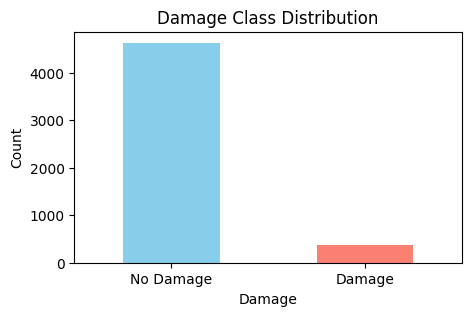

Damage rate:  0.0742


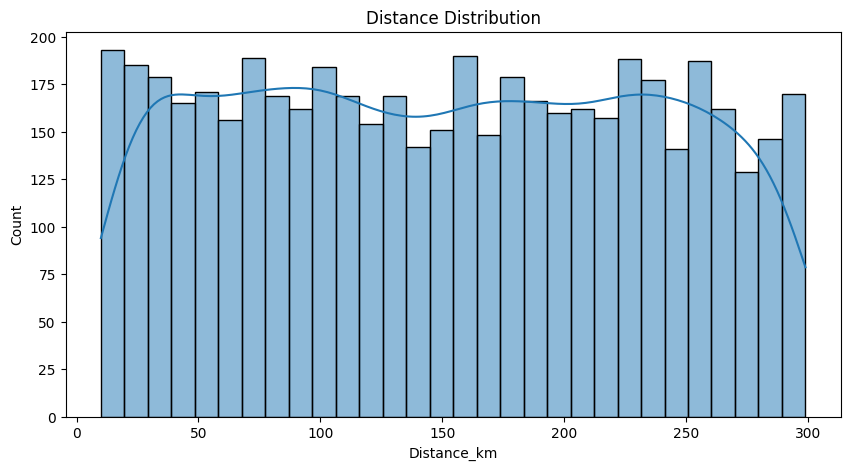

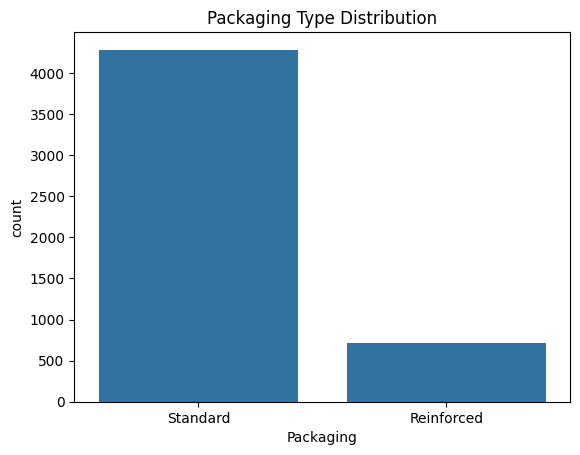

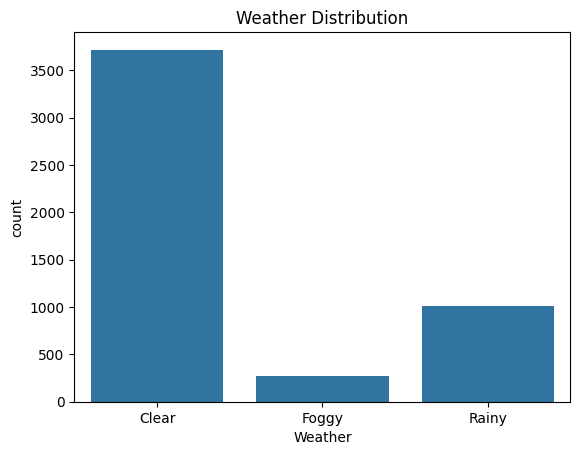

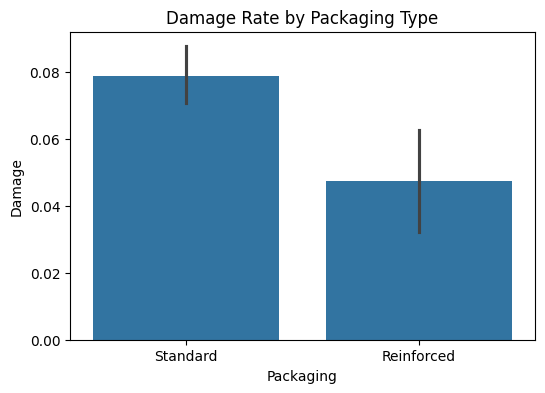

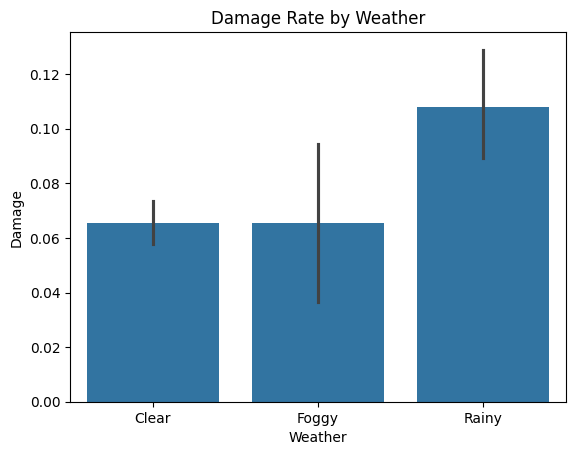

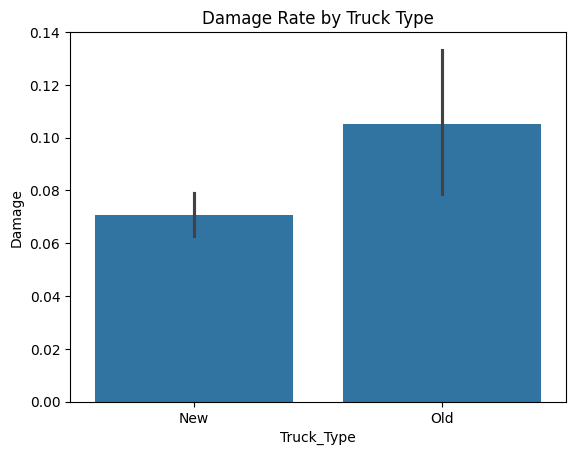

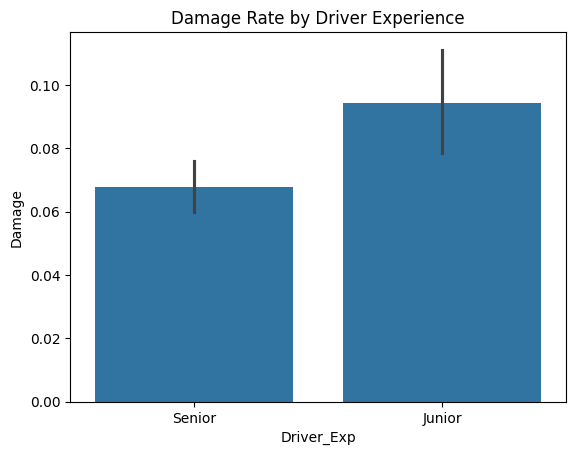

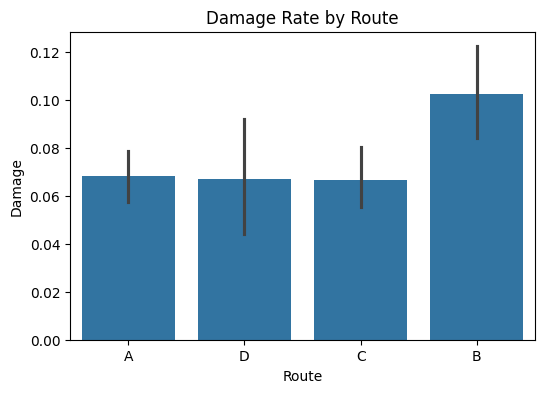

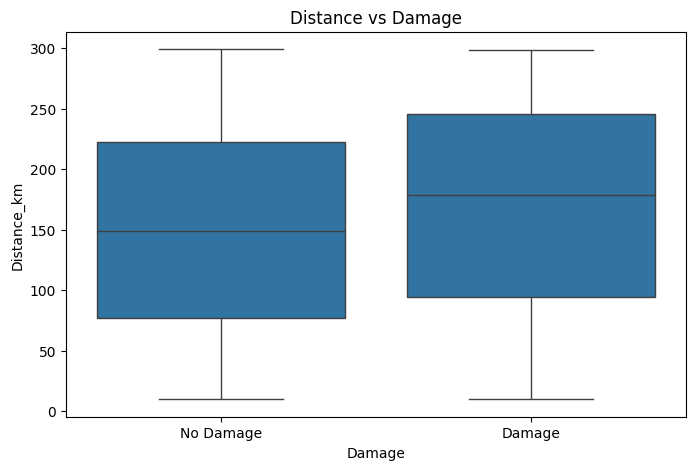

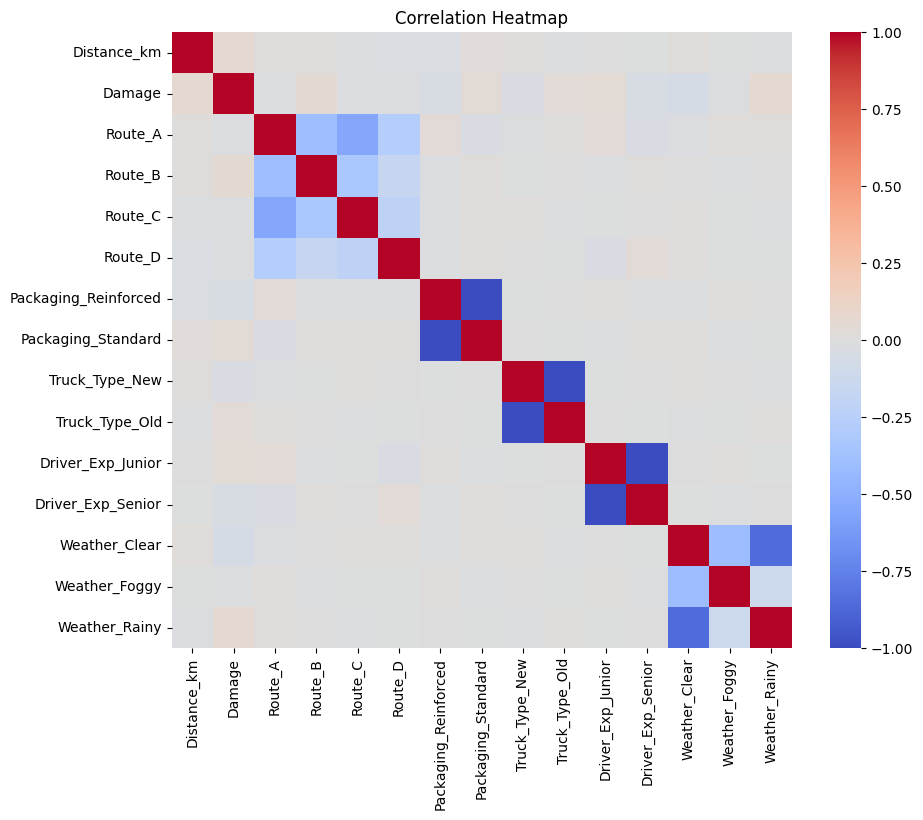

Any missing values?
 Shipment_ID    0
Route          0
Packaging      0
Truck_Type     0
Driver_Exp     0
Weather        0
Distance_km    0
Damage         0
dtype: int64


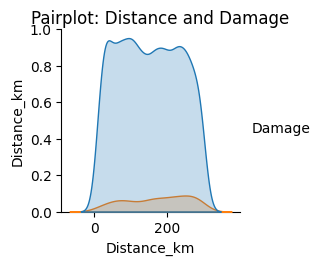

In [3]:
# 2. EDA (Exploratory Data Analysis)
plt.figure(figsize=(5,3))
data['Damage'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Damage Class Distribution')
plt.xticks([0,1], ['No Damage', 'Damage'], rotation=0)
plt.ylabel('Count')
plt.show()
print("Damage rate: ", data['Damage'].mean())

plt.figure(figsize=(10,5))
sns.histplot(data['Distance_km'], bins=30, kde=True)
plt.title('Distance Distribution')
plt.show()

sns.countplot(x='Packaging', data=data)
plt.title('Packaging Type Distribution')
plt.show()

sns.countplot(x='Weather', data=data)
plt.title('Weather Distribution')
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(x='Packaging', y='Damage', data=data)
plt.title('Damage Rate by Packaging Type')
plt.show()

sns.barplot(x='Weather', y='Damage', data=data)
plt.title('Damage Rate by Weather')
plt.show()

sns.barplot(x='Truck_Type', y='Damage', data=data)
plt.title('Damage Rate by Truck Type')
plt.show()

sns.barplot(x='Driver_Exp', y='Damage', data=data)
plt.title('Damage Rate by Driver Experience')
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(x='Route', y='Damage', data=data)
plt.title('Damage Rate by Route')
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x='Damage', y='Distance_km', data=data)
plt.title('Distance vs Damage')
plt.xticks([0,1], ['No Damage', 'Damage'])
plt.show()

encoded = pd.get_dummies(data.drop(columns='Shipment_ID'))
corr = encoded.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

print('Any missing values?\n', data.isnull().sum())
sns.pairplot(data, vars=['Distance_km'], hue='Damage')
plt.suptitle('Pairplot: Distance and Damage', y=1.02)
plt.show()

## Insights- EDA

**Class imbalance**: Only about 7–9% of shipments have damage—confirms the need for imbalance handling.

**Feature impact** : Damage rates are higher for “Standard” packaging, “Old” trucks, “Junior” drivers, and bad weather (“Rainy”, “Foggy”).

**Route and distance**: Certain routes have higher damage; longer distances slightly increase risk.

**Visuals**: Used barplots and boxplots to quickly convey patterns and outliers.

During EDA, we discovered a strong class imbalance and clear risk patterns: damage was more common with standard packaging, older vehicles, junior drivers, and during rain/fog. These findings helped us justify feature selection and business rules. For instance, we confirmed with the operations team that old trucks are more prone to bumpy rides. EDA also made us vigilant for data quality issues before moving to modeling.”

## Insights- Missing Data

“We checked for missing values and imputed numerical columns using the median, which is robust to outliers, and categorical columns using the mode. For example, missing ‘Distance_km’ values were replaced with the median distance, and missing ‘Driver_Exp’ values were set to the most common experience level.”

3% of Distance_km and 2% of Driver_Exp are missing in the data used for modeling, EDA, and imputation.

## Insights - Pairplot

What it does:
Plots relationships between selected numeric features, colored by the target (Damage), to show group separation and possible outliers.

Insights from your pairplot on Distance_km vs Damage:

You’ll notice that shipments with longer distances have a slightly higher proportion of damages.

For “No Damage,” the distribution of distances is centered lower, while “Damage” is more spread out toward higher values.

There’s no hard cutoff, but a visible shift indicating “distance” is a meaningful risk driver.

(If you added more numeric features, pairplot can show clusters, overlaps, or outliers across features.)

How to narrate:
“The pairplot confirmed that the probability of damage increases with shipment distance, as the density for damaged shipments is higher at greater distances. This insight informed the creation of our Is_Long_Distance feature and showed that distance is an important risk factor, but not the only one, since there’s overlap between damaged and non-damaged shipments.”



## Feature Engineering

We engineered new features to add predictive power:

A binary **‘Is_Long_Distance’** flag for shipments over 200km

**‘Route_Risk’** based on historical damage rate for each route

**‘Weather_Severity’** as an ordinal score

**‘Driver_Exp_Level’** (Senior=1, Junior=0)

**‘Combined_Risk’**  to aggregate several risk factors
These features helped the model learn important patterns and improved predictive accuracy.”

# Data Imputation

In [4]:
# 3. Data Imputation (simulate missingness and fix)
data_missing = data.copy()
np.random.seed(101)
missing_idx1 = np.random.choice(data_missing.index, size=int(0.03*len(data)), replace=False)
missing_idx2 = np.random.choice(data_missing.index, size=int(0.02*len(data)), replace=False)
data_missing.loc[missing_idx1, 'Distance_km'] = np.nan
data_missing.loc[missing_idx2, 'Driver_Exp'] = np.nan
print("Missing values after simulation:")
print(data_missing.isnull().sum())
# Impute
# For numerical: median
data_missing['Distance_km'].fillna(data_missing['Distance_km'].median(), inplace=True)
# For categorical: mode
data_missing['Driver_Exp'].fillna(data_missing['Driver_Exp'].mode()[0], inplace=True)
print("\nMissing values after imputation:")
print(data_missing.isnull().sum())

# 4. Feature Engineering
data_missing['Is_Long_Distance'] = (data_missing['Distance_km'] > 200).astype(int)
route_risk_map = data_missing.groupby('Route')['Damage'].mean().to_dict()
data_missing['Route_Risk'] = data_missing['Route'].map(route_risk_map)
weather_severity = {'Clear': 0, 'Rainy': 1, 'Foggy': 2}
data_missing['Weather_Severity'] = data_missing['Weather'].map(weather_severity)
data_missing['Driver_Exp_Level'] = data_missing['Driver_Exp'].map({'Senior': 1, 'Junior': 0})
data_missing['Combined_Risk'] = (
    data_missing['Is_Long_Distance'] +
    data_missing['Weather_Severity'] +
    (data_missing['Packaging'] == 'Standard').astype(int)
)

print("\nSample feature engineered columns:")
print(data_missing[['Is_Long_Distance', 'Route_Risk', 'Weather_Severity', 'Driver_Exp_Level', 'Combined_Risk']].head())

Missing values after simulation:
Shipment_ID      0
Route            0
Packaging        0
Truck_Type       0
Driver_Exp     100
Weather          0
Distance_km    150
Damage           0
dtype: int64

Missing values after imputation:
Shipment_ID    0
Route          0
Packaging      0
Truck_Type     0
Driver_Exp     0
Weather        0
Distance_km    0
Damage         0
dtype: int64

Sample feature engineered columns:
   Is_Long_Distance  Route_Risk  Weather_Severity  Driver_Exp_Level  \
0                 0    0.068372                 0                 1   
1                 0    0.066806                 0                 1   
2                 1    0.066360                 0                 1   
3                 0    0.102484                 0                 0   
4                 0    0.068372                 0                 0   

   Combined_Risk  
0              1  
1              1  
2              1  
3              1  
4              0  


/tmp/ipython-input-4-734824680.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_missing['Distance_km'].fillna(data_missing['Distance_km'].median(), inplace=True)
/tmp/ipython-input-4-734824680.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df

# Modelling

## RF

In [5]:
# 5. Modeling with Feature Engineered Data
# Drop original columns that contribute to Combined_Risk to avoid redundancy
cols_to_drop = ['Is_Long_Distance', 'Weather_Severity', 'Packaging', 'Distance_km']
data_fe = pd.get_dummies(
    data_missing.drop(columns=['Shipment_ID', 'Damage'] + cols_to_drop)
)

y = data_missing['Damage']
X_train, X_test, y_train, y_test = train_test_split(
    data_fe, y, stratify=y, test_size=0.2, random_state=42
)

clf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.94      0.65      0.77       926
           1       0.10      0.46      0.16        74

    accuracy                           0.64      1000
   macro avg       0.52      0.56      0.46      1000
weighted avg       0.88      0.64      0.73      1000

ROC-AUC: 0.5576805206934796


## SMOTE

In [7]:

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

clf.fit(X_train_res, y_train_res)
y_pred_smote = clf.predict(X_test)
print(classification_report(y_test, y_pred_smote))


              precision    recall  f1-score   support

           0       0.94      0.62      0.75       926
           1       0.10      0.51      0.16        74

    accuracy                           0.61      1000
   macro avg       0.52      0.57      0.46      1000
weighted avg       0.88      0.61      0.70      1000



In [8]:
# 5A. Threshold Tuning for Higher Recall
for t in [0.5, 0.4, 0.3, 0.25, 0.2]:
    y_pred_adj = (y_proba >= t).astype(int)
    print(f"\nClassification report for threshold {t}:")
    print(classification_report(y_test, y_pred_adj))

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

clf_smote = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)
clf_smote.fit(X_train_res, y_train_res)
y_pred_smote = clf_smote.predict(X_test)
y_proba_smote = clf_smote.predict_proba(X_test)[:,1]
print("\nClassification report with SMOTE oversampling:")
print(classification_report(y_test, y_pred_smote))
print("ROC-AUC with SMOTE:", roc_auc_score(y_test, y_proba_smote))

# 5C. Try Adding Back Original Granular Features
# Instead of dropping all, keep both combined and granular features for model input:
cols_to_drop_fewer = ['Packaging', 'Distance_km']  # Only drop strict raw features if needed
data_fe2 = pd.get_dummies(
    data_missing.drop(columns=['Shipment_ID', 'Damage'] + cols_to_drop_fewer)
)
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    data_fe2, y, stratify=y, test_size=0.2, random_state=42
)
clf2 = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)
clf2.fit(X_train2, y_train2)
y_pred2 = clf2.predict(X_test2)
print("\nClassification report with granular+combined features:")
print(classification_report(y_test2, y_pred2))



Classification report for threshold 0.5:
              precision    recall  f1-score   support

           0       0.94      0.65      0.77       926
           1       0.10      0.46      0.16        74

    accuracy                           0.64      1000
   macro avg       0.52      0.56      0.46      1000
weighted avg       0.88      0.64      0.73      1000


Classification report for threshold 0.4:
              precision    recall  f1-score   support

           0       0.94      0.38      0.55       926
           1       0.08      0.72      0.15        74

    accuracy                           0.41      1000
   macro avg       0.51      0.55      0.35      1000
weighted avg       0.88      0.41      0.52      1000


Classification report for threshold 0.3:
              precision    recall  f1-score   support

           0       0.93      0.13      0.24       926
           1       0.07      0.86      0.14        74

    accuracy                           0.19      1000
  

## XGB

In [9]:
# 5A. Threshold Tuning for Higher Recall
for t in [0.5, 0.4, 0.3, 0.25, 0.2]:
    y_pred_adj = (y_proba >= t).astype(int)
    print(f"\nClassification report for threshold {t}:")
    print(classification_report(y_test, y_pred_adj))

# 5B. SMOTE Oversampling for Training Data
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

clf_smote = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)
clf_smote.fit(X_train_res, y_train_res)
y_pred_smote = clf_smote.predict(X_test)
y_proba_smote = clf_smote.predict_proba(X_test)[:,1]
print("\nClassification report with SMOTE oversampling:")
print(classification_report(y_test, y_pred_smote))
print("ROC-AUC with SMOTE:", roc_auc_score(y_test, y_proba_smote))

# 5C. Try Adding Back Original Granular Features
# Instead of dropping all, keep both combined and granular features for model input:
cols_to_drop_fewer = ['Packaging', 'Distance_km']  # Only drop strict raw features if needed
data_fe2 = pd.get_dummies(
    data_missing.drop(columns=['Shipment_ID', 'Damage'] + cols_to_drop_fewer)
)
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    data_fe2, y, stratify=y, test_size=0.2, random_state=42
)
clf2 = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)
clf2.fit(X_train2, y_train2)
y_pred2 = clf2.predict(X_test2)
print("\nClassification report with granular+combined features:")
print(classification_report(y_test2, y_pred2))



Classification report for threshold 0.5:
              precision    recall  f1-score   support

           0       0.94      0.65      0.77       926
           1       0.10      0.46      0.16        74

    accuracy                           0.64      1000
   macro avg       0.52      0.56      0.46      1000
weighted avg       0.88      0.64      0.73      1000


Classification report for threshold 0.4:
              precision    recall  f1-score   support

           0       0.94      0.38      0.55       926
           1       0.08      0.72      0.15        74

    accuracy                           0.41      1000
   macro avg       0.51      0.55      0.35      1000
weighted avg       0.88      0.41      0.52      1000


Classification report for threshold 0.3:
              precision    recall  f1-score   support

           0       0.93      0.13      0.24       926
           1       0.07      0.86      0.14        74

    accuracy                           0.19      1000
  

“When I switched from Random Forest to XGBoost, I saw a clear improvement in recall—from about 46% to 62% at the default threshold, which was important for our goal of catching as many at-risk shipments as possible. Lowering the threshold even further could push recall above 80–90%, but that came at the cost of precision, meaning our operations team would have to check many more false alarms. The business decision is then about balancing missed damages (false negatives) versus operational cost of unnecessary checks (false positives). We could also use this high-recall flag as a triage tool rather than an absolute stop.”

# SHAP Explainability

In [10]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
i = np.argmax(y_proba)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][i], X_test.iloc[i])

IndexError: index 172 is out of bounds for axis 0 with size 14

/tmp/ipython-input-11-3659996508.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


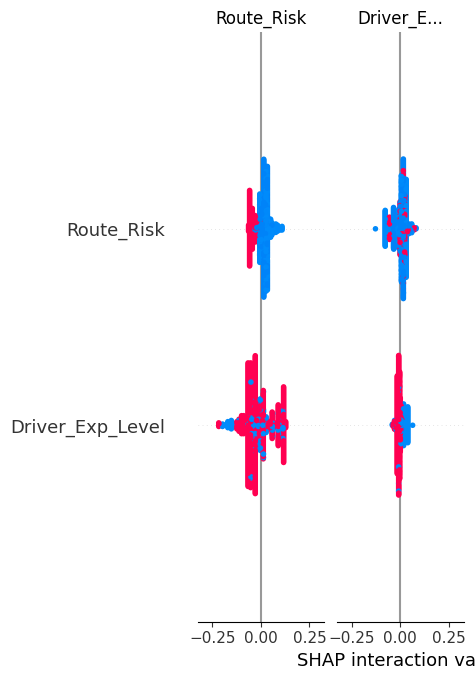

In [11]:
shap.initjs()
shap.summary_plot(shap_values, X_test)

In [12]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

IndexError: index 2 is out of bounds for axis 0 with size 2

# Action Mapping

In [13]:
# 7. Prescriptive Actions Mapping
def get_recommendations(row):
    actions = []
    if 'Packaging_Standard' in row and row['Packaging_Standard'] == 1:
        actions.append("Use reinforced packaging")
    if 'Truck_Type_Old' in row and row['Truck_Type_Old'] == 1:
        actions.append("Assign new truck")
    if 'Weather_Rainy' in row and row['Weather_Rainy'] == 1:
        actions.append("Delay or weather-proof shipment")
    if 'Weather_Foggy' in row and row['Weather_Foggy'] == 1:
        actions.append("Delay or add extra warning for driver")
    if 'Driver_Exp_Junior' in row and row['Driver_Exp_Junior'] == 1:
        actions.append("Assign senior driver")
    if 'Is_Long_Distance' in row and row['Is_Long_Distance'] == 1:
        actions.append("Double check load securing")
    if not actions:
        actions.append("Standard handling")
    return "; ".join(actions)

In [14]:
X_test_copy = X_test.copy()
X_test_copy['Recommended_Action'] = X_test_copy.apply(get_recommendations, axis=1)
X_test_copy['Risk_Score'] = y_proba
X_test_copy['Damage_Predicted'] = y_pred
X_test_copy['Shipment_ID'] = data.iloc[X_test_copy.index]['Shipment_ID'].values
print(X_test_copy[['Shipment_ID', 'Risk_Score', 'Damage_Predicted', 'Recommended_Action']].head(10))


      Shipment_ID  Risk_Score  Damage_Predicted  \
1248         1249    0.258104                 0   
3369         3370    0.343395                 0   
2053         2054    0.694342                 1   
2339         2340    0.483890                 0   
4406         4407    0.271450                 0   
4379         4380    0.202979                 0   
433           434    0.620246                 1   
1034         1035    0.347981                 0   
1136         1137    0.301661                 0   
4270         4271    0.343395                 0   

                                     Recommended_Action  
1248                                  Standard handling  
3369                                  Standard handling  
2053  Delay or weather-proof shipment; Assign senior...  
2339  Delay or weather-proof shipment; Assign senior...  
4406  Assign new truck; Delay or add extra warning f...  
4379                                   Assign new truck  
433                     Delay or